In [1]:
# Import all neccessary libraries
# table data handling
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# multiobjective optimization related
from pymoo.util.nds.fast_non_dominated_sort import fast_non_dominated_sort as ndsort
from pymoo.factory import get_performance_indicator
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import utils
# others
from tqdm import tqdm

In [2]:
sns.set_style("white")
sns.set_palette(["black", "blue", "red"])
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})

## Read data

In [3]:
# Read data of volve problem
method_file_names = ['lexide', 'nsgaii', 'rvea']
method_names = ['Lex-DE', 'NSGA-II', 'RVEA']
reps = [1000,1001,1002,2000,2001]

objective_sim_names = [f'fit_{i}' for i in range(5)]
objective_cod_names = ['seis-mean', 'seis-spa', 'P-F-14', 'P-F-12', 'P-F-15C']
objective_cod_names_large_font = ['seis-\nmean', 'seis-\nspa', 'P-F-14', 'P-F-12', 'P-F15-C']

parameter_names = [
    'PMBK1_C','PMBK1_B','PMBK1_A',
    'PMBK2_C','PMBK2_B','PMBK2_A',
    'PMBK3_C','PMBK3_B','PMBK3_A',
    'PMBK4_C','PMBK4_B','PMBK4_A',
    'PMBK5_C','PMBK5_B','PMBK5_A',
    'POROBK1_C','POROBK2_C','POROBK3_C','POROBK4_C','POROBK5_C',
    'POROBK1_B','POROBK2_B','POROBK3_B','POROBK4_B','POROBK5_B',
    'POROBK1_A','POROBK2_A','POROBK3_A','POROBK4_A','POROBK5_A',
    'PERMZ_C','PERMZ_B','PERMZ_A',
    'TBLK1_C3C2','TBLK1_C1B3','TBLK1_B2B1','TBLK1_B1A5',
    'TBLK2_C3C2','TBLK2_C1B3','TBLK2_B2B1','TBLK2_B1A5',
    'TBLK3_C3C2','TBLK3_C1B3','TBLK3_B2B1','TBLK3_B1A5',
    'TBLK4_C3C2','TBLK4_C1B3','TBLK4_B2B1','TBLK4_B1A5',
    'TBLK5_C3C2','TBLK5_C1B3','TBLK5_B2B1','TBLK5_B1A5',
    'SWA1','SOA1',
    'F_6_78','F_4_6','F_4_5','F_7_8',
    'AQ_PORVM','MAIN_OWC',
]

In [4]:
volve_hdfs = []
for i, method_file_name in tqdm(enumerate(method_file_names)):
    for j, rep in enumerate(reps):
        tmp = pd.read_hdf(f'volve/{method_file_name}_fzy_synth_seed{rep}_POP.hdf5').sort_values(['eval'], ignore_index=True)
        tmp['Method'] = method_names[i] # specify the method
        tmp['Repetition'] = j           # specify the repetition
        tmp_obj_val = tmp[objective_sim_names].values
        nd_idx = ndsort(tmp_obj_val)[0]
        is_nd = np.array([False]*len(tmp))
        is_nd[nd_idx] = True
        tmp['is_nd'] = list(is_nd)      # specify whether the individual is non-dominated
        volve_hdfs.append(tmp)
volve_dat = pd.concat(volve_hdfs).sort_values(['Method','Repetition','eval'])
volve_dat.head(3)

3it [00:19,  6.38s/it]


,eval,gen,ind,PMBK1_C,PMBK1_B,PMBK1_A,PMBK2_C,PMBK2_B,PMBK2_A,PMBK3_C,...,WBP4:P-F-12,fitseismic_fzy_mean_a,fit_0,fit_1,fit_2,fit_3,fit_4,Method,Repetition,is_nd
0,1.0,1.0,0.0,4.748332,1.247545,6.676839,3.634244,6.171084,1.880162,0.764613,...,0.035682,0.378636,0.378636,0.331398,5.083091,2.092915,1.926323,Lex-DE,0,False
1,2.0,1.0,1.0,2.020266,3.928738,4.178813,3.348464,2.592172,4.137665,6.124746,...,0.022651,0.298008,0.298008,0.303670,5.958015,7.721739,1.863506,Lex-DE,0,False
2,3.0,1.0,2.0,1.363411,2.145837,3.385061,4.131874,5.790118,2.565884,3.080793,...,0.021110,0.352635,0.352635,0.332471,5.907281,67.807290,22.564207,Lex-DE,0,False


## Preprocessing

1. scale the five objective values into $[0,1]$ based on all individuals
2. scale the five objective values into $[0,1]$ based on non-dominated individuals
3. scale the 61 parameter values into $[0,1]$ based on all individuals

In [5]:
# Scale the objective values and parameter values between 0 and 1
scaler = MinMaxScaler()

# scale by all individuals in 3 methods x 5 repetitions x 2000 evaluations
volve_fit_scaled_by_all = scaler.fit_transform(volve_dat[objective_sim_names].to_numpy())
volve_fit_scaled_by_all = pd.DataFrame(volve_fit_scaled_by_all, columns=[f'{item}_scaled_by_all' for item in objective_sim_names])

# scale by all individuals in 3 methods x 5 repetitions x number of non-dominated individuals
volve_fit_scaled_by_nd = scaler.fit(volve_dat[volve_dat.is_nd][objective_sim_names].to_numpy()).transform(volve_dat[objective_sim_names].to_numpy())
volve_fit_scaled_by_nd = pd.DataFrame(volve_fit_scaled_by_nd, columns=[f'{item}_scaled_by_nd' for item in objective_sim_names])

# scale by all individuals in 3 methods x 5 repetitions x 2000 evaluations
volve_param_scaled_by_all = scaler.fit(volve_dat[parameter_names].to_numpy()).transform(volve_dat[parameter_names].to_numpy())
volve_param_scaled_by_all = pd.DataFrame(volve_param_scaled_by_all, columns=[f'{item}_scaled_by_all' for item in parameter_names])

volve_dat_processed = pd.concat([
    volve_dat.reset_index(drop=True),
    volve_fit_scaled_by_all.reset_index(drop=True),
    volve_param_scaled_by_all.reset_index(drop=True),
    volve_fit_scaled_by_nd.reset_index(drop=True)
], axis=1)

volve_dat_processed.to_csv('volve.processed.csv', index=False) # save to csv

In [6]:
volve_dat_processed = pd.read_csv('volve.processed.csv')
volve_dat_processed.head(3)

,eval,gen,ind,PMBK1_C,PMBK1_B,PMBK1_A,PMBK2_C,PMBK2_B,PMBK2_A,PMBK3_C,...,F_4_6_scaled_by_all,F_4_5_scaled_by_all,F_7_8_scaled_by_all,AQ_PORVM_scaled_by_all,MAIN_OWC_scaled_by_all,fit_0_scaled_by_nd,fit_1_scaled_by_nd,fit_2_scaled_by_nd,fit_3_scaled_by_nd,fit_4_scaled_by_nd
0,1.0,1.0,0.0,4.748332,1.247545,6.676839,3.634244,6.171084,1.880162,0.764613,...,0.441167,0.137556,0.213543,0.133372,0.322297,0.679235,0.732621,0.106768,0.013639,0.023280
1,2.0,1.0,1.0,2.020266,3.928738,4.178813,3.348464,2.592172,4.137665,6.124746,...,0.960296,0.458118,0.757892,0.681159,0.541778,0.478331,0.645203,0.121175,0.044272,0.022630
2,3.0,1.0,2.0,1.363411,2.145837,3.385061,4.131874,5.790118,2.565884,3.080793,...,0.780134,0.135049,0.128558,0.240503,0.291811,0.614448,0.736006,0.120340,0.371268,0.236886


## Scaled hypervolume

In [7]:
# Compute hypervolume
with open('volve.hv.csv', 'w') as f:
    print('Method', 'Repetition', 'Hypervolume', sep=',', file=f)
hv_calculator = get_performance_indicator('hv', ref_point=np.ones(len(objective_sim_names)))
for method_name in tqdm(method_names):
    for rep in range(len(reps)):
        nd_ind = volve_dat_processed[
            (volve_dat_processed.is_nd) & (volve_dat_processed.Method==method_name) & (volve_dat_processed.Repetition==rep)
        ][[f'{item}_scaled_by_nd' for item in objective_sim_names]].values
        with open('volve.hv.csv', 'a') as f:
            print(method_name, rep, hv_calculator.do(nd_ind), sep=',', file=f)
volve_hv = pd.read_csv('volve.hv.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.55s/it]


In [8]:
# Get statistics
volve_hv.groupby(['Method']).aggregate([max, np.argmax, np.median, min, np.mean, np.std]).Hypervolume

,max,argmax,median,min,mean,std
Method,,,,,,
Lex-DE,0.985183,2,0.933876,0.836036,0.925288,0.056544
NSGA-II,0.674088,2,0.628429,0.490414,0.597285,0.077462
RVEA,0.283847,2,0.242893,0.226898,0.248679,0.024021


## Parallel coordinate graph for the non-dominated solutions in the runs with best hypervolume

In [9]:
# Prepare data table for plotting parallel coordinate graph
volve_dat_processed['ID'] = range(len(volve_dat_processed))
volve_dat_processed_melt = pd.melt(
    volve_dat_processed[
        (volve_dat_processed.is_nd) & \
        (
            (volve_dat_processed.Method=='Lex-DE') &(volve_dat_processed.Repetition==2)| \
            (volve_dat_processed.Method=='RVEA')   &(volve_dat_processed.Repetition==2)| \
            (volve_dat_processed.Method=='NSGA-II')&(volve_dat_processed.Repetition==2)
        )
    ],
    id_vars     = ['Method', 'ID'],
    value_vars  = [f'{item}_scaled_by_nd' for item in objective_sim_names],
    var_name    = 'Objective Name',
    value_name  = 'Value'
)
volve_dat_processed_melt.head(3)

,Method,ID,Objective Name,Value
0,Lex-DE,4366,fit_0_scaled_by_nd,0.317025
1,Lex-DE,4562,fit_0_scaled_by_nd,0.284070
2,Lex-DE,4605,fit_0_scaled_by_nd,0.265872


C:\Users\heyif\AppData\Local\Temp/ipykernel_20504/3270885735.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(objective_cod_names)


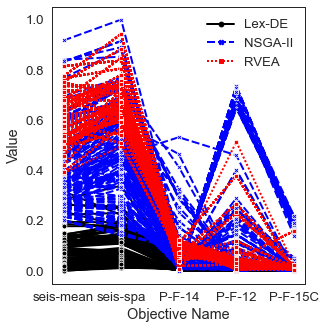

In [10]:
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})
fig = plt.figure(figsize=(6.4,4.8))
plt.subplots_adjust(left=0.15, bottom=0.2, right=0.7, top=1)
ax = fig.add_subplot(111)
sns.lineplot(
    data=volve_dat_processed_melt,
    x='Objective Name', y='Value',
    hue='Method', style='Method', markers=['o', 'X', 's'],
    estimator=None, units='ID')
ax.set_xticklabels(objective_cod_names)
plt.legend(title='', frameon=False, bbox_to_anchor=(1,1))

0it [00:00, ?it/s]C:\Users\heyif\AppData\Local\Temp/ipykernel_20504/1348161813.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(objective_cod_names_large_font)


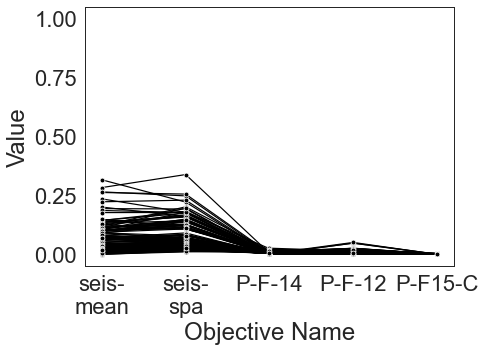

1it [00:00,  2.07it/s]C:\Users\heyif\AppData\Local\Temp/ipykernel_20504/1348161813.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(objective_cod_names_large_font)


<Figure size 432x288 with 0 Axes>

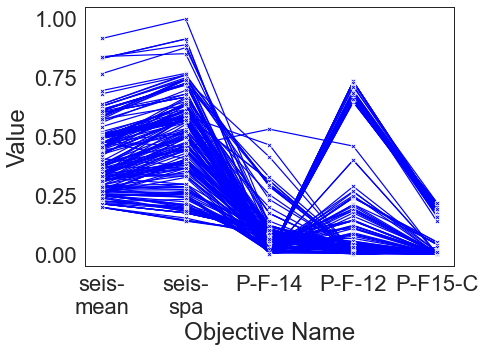

2it [00:00,  2.00it/s]C:\Users\heyif\AppData\Local\Temp/ipykernel_20504/1348161813.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(objective_cod_names_large_font)


<Figure size 432x288 with 0 Axes>

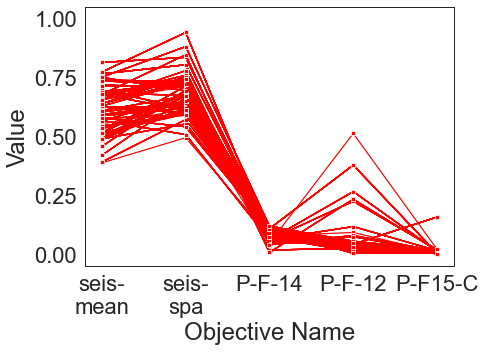

3it [00:01,  1.65it/s]


<Figure size 432x288 with 0 Axes>

In [21]:
for i, method_name in tqdm(enumerate(method_names)):
    sns.set_context("paper", font_scale=2.5)
    fig = plt.figure(figsize=(6.4,4.8))
    ax = fig.add_subplot(111)
    plt.subplots_adjust(left=0.2, bottom=0.25, right=1, top=1)
    sns.lineplot(
        data=volve_dat_processed_melt,
        x='Objective Name', y='Value',
        hue='Method', style_order=[method_name], style='Method', markers=['o', 'X', 's'][i], legend=False,
        estimator=None, units='ID')
    ax.set_xticklabels(objective_cod_names_large_font)
    plt.ylim(-0.05, 1.05)
    plt.savefig(f'volve.parallel.{method_name}.eps')
    plt.show()
    plt.clf()

## Scatterplot for the non-dominated solutions in the runs with the best hypervolume

In [12]:
data = volve_dat_processed[
        (volve_dat_processed.is_nd) & \
        (
            (volve_dat_processed.Method=='Lex-DE') &(volve_dat_processed.Repetition==2)| \
            (volve_dat_processed.Method=='RVEA')   &(volve_dat_processed.Repetition==2)| \
            (volve_dat_processed.Method=='NSGA-II')&(volve_dat_processed.Repetition==2)
        )
    ][[f'{item}_scaled_by_nd' for item in objective_sim_names]+['Method']]
data.columns = objective_cod_names + ['Method']
data = data.sort_values(['Method'], ascending=False)
data.head(3)

,seis-mean,seis-spa,P-F-14,P-F-12,P-F-15C,Method
24032,0.499834,0.674178,0.105709,0.045696,0.017696,RVEA
24488,0.515673,0.692928,0.111227,0.018691,0.017588,RVEA
24492,0.515673,0.692928,0.111227,0.018691,0.017588,RVEA


<Figure size 432x288 with 0 Axes>

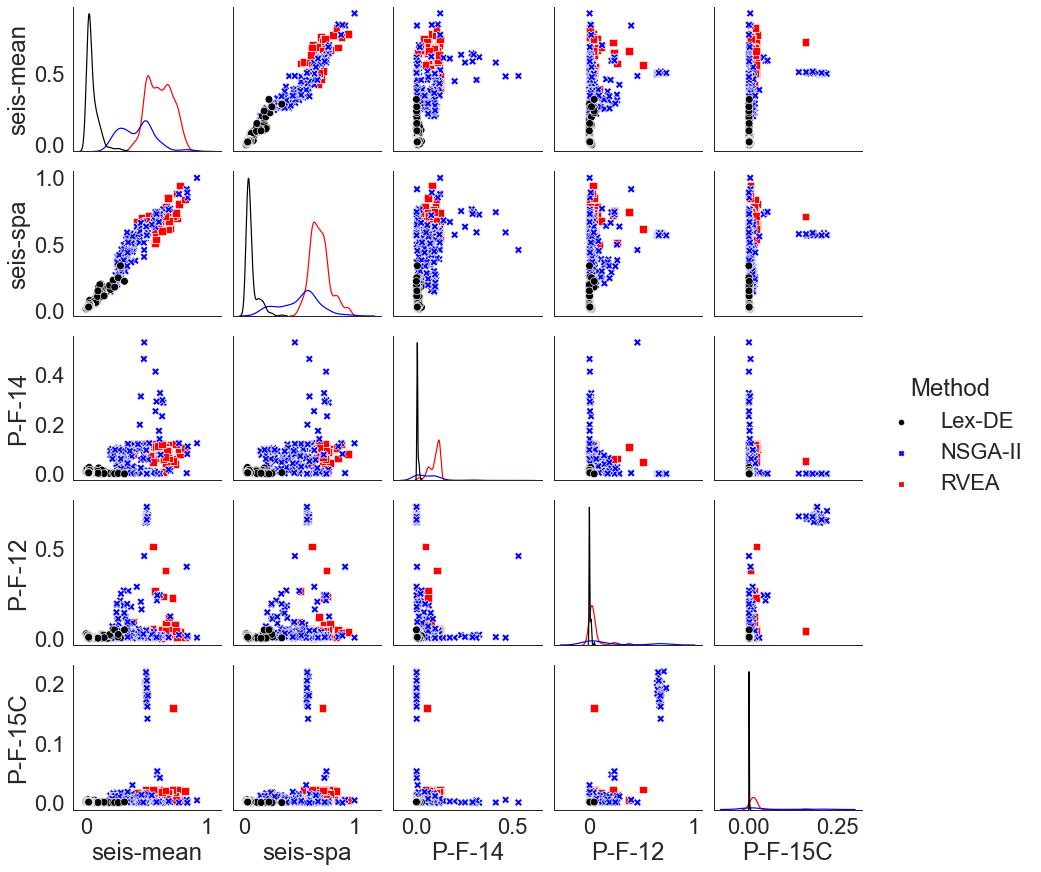

In [13]:
sns.set_context("paper", font_scale=2.5)
fig = plt.figure()
plt.subplots_adjust(left=0.15, bottom=0.15, right=1, top=1)
sns.pairplot(
    data,
    hue='Method', hue_order=['Lex-DE', 'NSGA-II', 'RVEA'], markers=['s', 'X', 'o'],
    diag_kws=dict(fill=False),
    plot_kws=dict(s=60)
)
plt.savefig('volve.scatter.eps')

## Lineplot for the objectives by generations

0it [00:00, ?it/s]

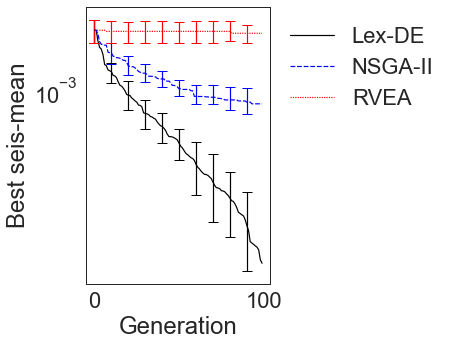

1it [00:05,  5.37s/it]

<Figure size 432x288 with 0 Axes>

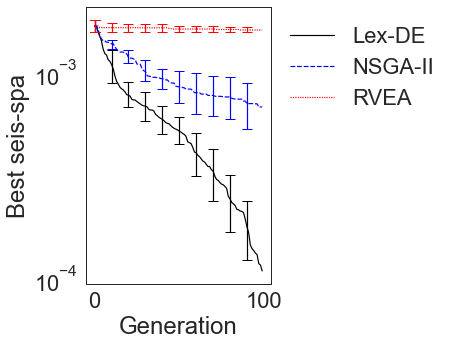

2it [00:10,  5.34s/it]

<Figure size 432x288 with 0 Axes>

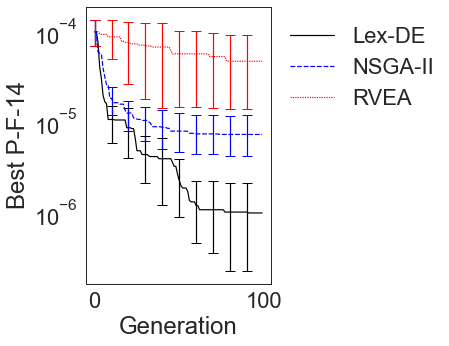

3it [00:16,  5.35s/it]

<Figure size 432x288 with 0 Axes>

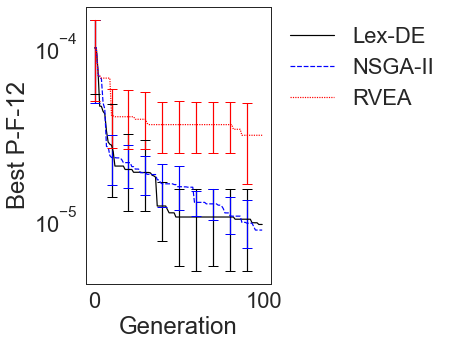

4it [00:21,  5.28s/it]

<Figure size 432x288 with 0 Axes>

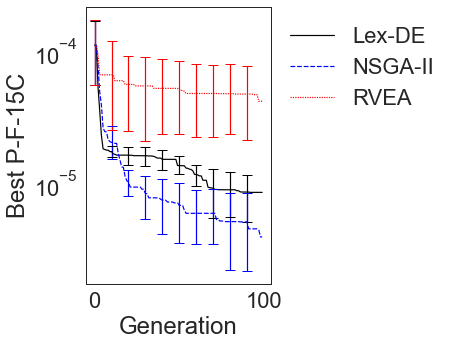

5it [00:26,  5.29s/it]


<Figure size 432x288 with 0 Axes>

In [14]:
for i, objective_sim_name in tqdm(enumerate(objective_sim_names)):
    sns.set_context("paper", font_scale=2.5)
    fig = plt.figure(figsize=(6.4,4.8))
    ax = fig.add_subplot(111)
    plt.subplots_adjust(left=0.2, bottom=0.2, right=0.6, top=1)
    best_fit_dats = []
    for method_name in method_names:
        for rep in range(len(reps)):
            tmp = utils.best_by_gen(
                volve_dat_processed[
                    (volve_dat_processed.Method==method_name) & \
                    (volve_dat_processed.Repetition==rep)
                ][f'{objective_sim_name}_scaled_by_all'].values,
                fit_name=objective_cod_names[i]
            )
            tmp['Method'] = method_name
            # tmp['Repetition'] = rep 
            best_fit_dats.append(tmp)
    best_fit_dats = pd.concat(best_fit_dats).reset_index(drop=True)
    sns.lineplot(data=best_fit_dats,
                 x='Generation', y=f'Best {objective_cod_names[i]}',
                 hue='Method', style='Method',
                 err_style="bars", err_kws={"errorevery": 10,
                                            "capsize": 5})
    plt.yscale('log')
    plt.legend(title='', frameon=False, bbox_to_anchor=(1,1))
    plt.savefig(f'volve.{objective_cod_names[i]}.eps')
    plt.show()
    plt.clf()

## Scaled euclidean distance to the ground truth of the non-dominated solutions in the parameter space

In [15]:
volve_opt = pd.read_csv('volve.opt.dat', header=None)
volve_opt.columns = ['Parameter Name', 'Value']
volve_opt.index = volve_opt['Parameter Name']
volve_opt = volve_opt.reindex(parameter_names).reset_index(drop=True)
volve_opt_scaled = scaler.fit(volve_dat[parameter_names].to_numpy()).transform(volve_opt.Value.values.reshape(1, -1))
volve_opt['Value'] = volve_opt_scaled.flatten()
volve_opt.head(3)

,Parameter Name,Value
0,PMBK1_C,0.420000
1,PMBK1_B,0.880000
2,PMBK1_A,0.653846


In [16]:
# dist = lambda df: np.sum(np.abs(df), axis=1)
dist = lambda df: np.linalg.norm(df, axis=1)
with open('volve.dist.csv', 'w') as f:
    print('Method,Repetition,Best Case,Median Case,Worst Case,Average Case', file=f)
for method in tqdm(method_names):
    for rep in range(len(reps)):
        df = volve_dat_processed[
            (volve_dat_processed.is_nd) & (volve_dat_processed.Method==method) & (volve_dat_processed.Repetition==rep)
        ][[f'{item}_scaled_by_all' for item in parameter_names]].values - volve_opt.Value.values
        with open('volve.dist.csv', 'a') as f:
            print(
                method,
                rep,
                np.min(dist(df)),
                np.median(dist(df)),
                np.max(dist(df)),
                np.mean(dist(df)),
                sep=',',
                file=f
            )

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 57.70it/s]


In [17]:
volve_dist = pd.read_csv('volve.dist.csv')
volve_dist.groupby('Method').aggregate([np.min, np.argmin, np.median, np.max, np.mean, np.std])['Average Case']

,amin,argmin,median,amax,mean,std
Method,,,,,,
Lex-DE,2.102029,4,2.368322,3.076021,2.464229,0.375760
NSGA-II,2.382832,1,2.763686,2.840008,2.674617,0.187253
RVEA,2.947334,4,3.127269,3.221582,3.085658,0.109827


In [18]:
# dist = lambda df: np.sum(np.abs(df), axis=1)
dist = lambda df: np.linalg.norm(df, axis=1)
with open('volve.dist.per.point.csv', 'w') as f:
    print('Method,Repetition,Distance', file=f)
for method in tqdm(method_names):
    for rep in range(len(reps)):
        df = volve_dat_processed[
            (volve_dat_processed.is_nd) & (volve_dat_processed.Method==method) & (volve_dat_processed.Repetition==rep)
        ][[f'{item}_scaled_by_all' for item in parameter_names]].values - volve_opt.Value.values
        with open('volve.dist.per.point.csv', 'a') as f:
            for d in dist(df):
                print(method, rep, d, sep=',', file=f)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 51.70it/s]


In [19]:
volve_dist_per_point = pd.read_csv('volve.dist.per.point.csv')
volve_dist_per_point.head(3)

,Method,Repetition,Distance
0,Lex-DE,0,2.543448
1,Lex-DE,0,2.543448
2,Lex-DE,0,2.494314


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


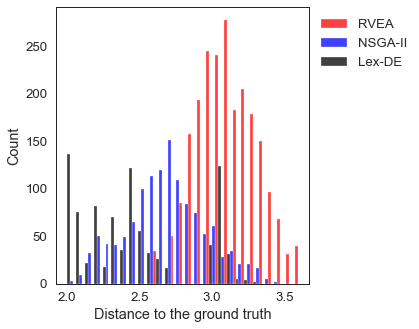

In [20]:
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})
fig = plt.figure(figsize=(6.4,4.8))
plt.subplots_adjust(left=0.15, bottom=0.2, right=0.7, top=1)
sns.histplot(data=volve_dist_per_point, x='Distance', hue='Method', multiple="dodge")
plt.xlabel('Distance to the ground truth')
plt.legend(title='', labels=["RVEA", "NSGA-II", "Lex-DE"], frameon=False, bbox_to_anchor=(1,1))
plt.savefig('volve.dist.hist.eps')